In [1]:
%matplotlib inline
from functools import partial

import sys
sys.path.append('../cholla-vis')

import matplotlib.pyplot as plt
import numpy as np
import scipy.special
import unyt

cs_isothermal_kpc_per_kyr = np.sqrt(unyt.kboltz_cgs * 1e4 * unyt.K 
                                    / (0.6 *unyt.mh_cgs)).to('kpc/kyr').v

In [2]:
%load_ext autoreload
%autoreload 1
%aimport ICs

In [21]:
(708 *0.005)

3.54

In [8]:
Rgas_truncation_radius = (708 *0.005) / 2.0 - 0.3

In [1]:
gas_disk_kw = dict(Mgas = 0.15 * 6.5e10, R_g = 5.4, Rgas_truncation_radius = Rgas_truncation_radius,
                   alpha = 0.02)

nominal_gas_Sigma0, prof = ICs.get_sigma_gas_disk(
    force_unity_Sigma0 = True, **gas_disk_kw)
_, prof_with_Sigma0 = ICs.get_sigma_gas_disk(
    force_unity_Sigma0 = False, **gas_disk_kw)

tmp = ICs.get_defaults()
halo = tmp['halo']
stellar_disk = tmp['stellar_disk']
razorthin_gas_disk =  tmp['razorthin_gas_disk']
starparticle_disk = tmp['starparticle_disk']

NameError: name 'Rgas_truncation_radius' is not defined

In [ ]:
def my_test_plot():
    # this is just a test of the calculations involving a
    # truncated gas-disk

    R_vals = np.linspace(1.0, 12, num = 1025)
    untruncated_gas_disk = ICs.vcirc2_gas_builder(
        Rgas_truncation_radius = 0.0)
    truncated_gas_disk_default_alpha = ICs.vcirc2_gas_builder(
        Rgas_truncation_radius = 9.9,
        alpha = 0.005)
    fig,ax = plt.subplots(1,1)
    ax.plot(R_vals, untruncated_gas_disk(R_vals,0.0),
            label = 'untruncated')
    ax.plot(R_vals, truncated_gas_disk_default_alpha(R_vals,0.0),
            label = 'truncated')
    ax.set_ylabel(r'$v_{\rm circ}^2$ [${\rm km}^2\ {\rm s}^{-2}$]')
    ax.set_xlabel(r'R (kpc)')
    ax.legend()
my_test_plot()

A new version of galpy (1.10.1) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!
/ix/eschneider/mabruzzo/envs-ondemand/py_310/lib/python3.10/site-packages/galpy/potential/AnyAxisymmetricRazorThinDiskPotential.py:132: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrate.quad(rforceint, 0, 2 * R, points=[R])[0]

/ix/eschneider/mabruzzo/envs-ondemand/py_310/lib/python3.10/site-packages/galpy/potential/AnyAxisymmetricRazorThinDiskPotential.py:132: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integrate.quad(rforceint, 0, 2 * R, points=[R])[0]



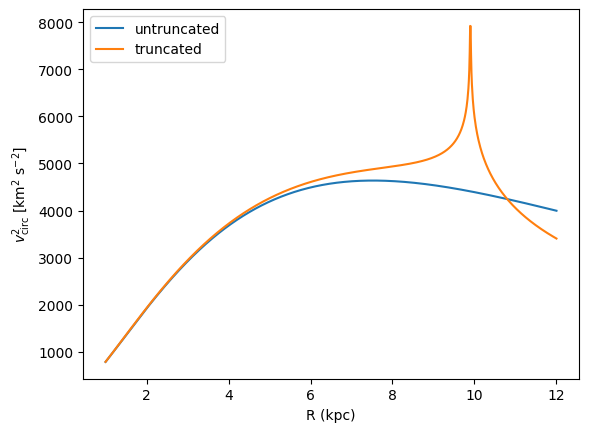

In [9]:
def my_test_plot():
    # this is just a test of the calculations involving a
    # truncated gas-disk

    R_vals = np.linspace(1.0, 12, num = 1025)
    untruncated_gas_disk = ICs.vcirc2_gas_builder(
        Rgas_truncation_radius = 0.0)
    truncated_gas_disk_default_alpha = ICs.vcirc2_gas_builder(
        Rgas_truncation_radius = 9.9,
        alpha = 0.005)
    fig,ax = plt.subplots(1,1)
    ax.plot(R_vals, untruncated_gas_disk(R_vals,0.0),
            label = 'untruncated')
    ax.plot(R_vals, truncated_gas_disk_default_alpha(R_vals,0.0),
            label = 'truncated')
    ax.set_ylabel(r'$v_{\rm circ}^2$ [${\rm km}^2\ {\rm s}^{-2}$]')
    ax.set_xlabel(r'R (kpc)')
    ax.legend()
my_test_plot()

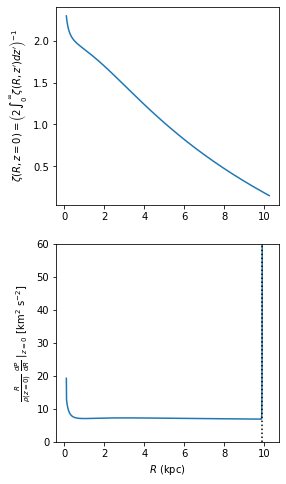

In [5]:
def checking_pressure_contributions():
    fig,ax_arr = plt.subplots(2,1, figsize = (4,8))

    R_vals = np.linspace(0.1,10.24, num = 1025)
    
    # The gas disk's mass density can be written as rho(R,z) = zeta(R,z) * Sigma(R)
    # -> here we are just computing zeta(R,0)
    zeta_midplane = ICs.calc_rho_midplane(R_vals,
                                          cs_isothermal_kpc_per_kyr = cs_isothermal_kpc_per_kyr,
                                          Sigma_gas_fn = None,
                                          static_components = [stellar_disk, halo])

    ax_arr[0].plot(R_vals, np.log(zeta_midplane))
    ax_arr[0].set_ylabel(r"$\zeta(R,z=0) = " +
                  r"\left(2 \int_0^{\infty} \zeta(R,z^\prime)dz^\prime\right)^{-1}$")
    
    
    # that computes the contribution of pressure in the circular velocity
    # calculation.
    #
    # Specifically, this returns `(R/rho) * (dP/dR)` in units of (km/s)^2. For a
    # radially exponential disk, the values will be negative.
    v2pressure = ICs.calc_vcirc2_presure_term(
        R_vals, cs_isothermal_kpc_per_kyr = cs_isothermal_kpc_per_kyr,
        Sigma_gas_fn = prof_with_Sigma0,
        static_components = [stellar_disk, halo],
        Rderiv_step_kpc = 1e-6)

    ax_arr[1].plot(R_vals, np.sqrt(-1 * v2pressure))
    ax_arr[1].set_ylabel(r'$\frac{R}{\rho(z = 0)}\ '
                         r'\left.\frac{dP}{dR}\ \right|_{z=0}$ '
                         r'[${\rm km}^2\ {\rm s}^{-2}$]')
    ax_arr[1].axvline(9.9, color = 'k', ls = ':')
    ax_arr[1].set_ylim(0.0, 60.0)
    ax_arr[1].set_xlabel(r'$R$ (kpc)')

checking_pressure_contributions()

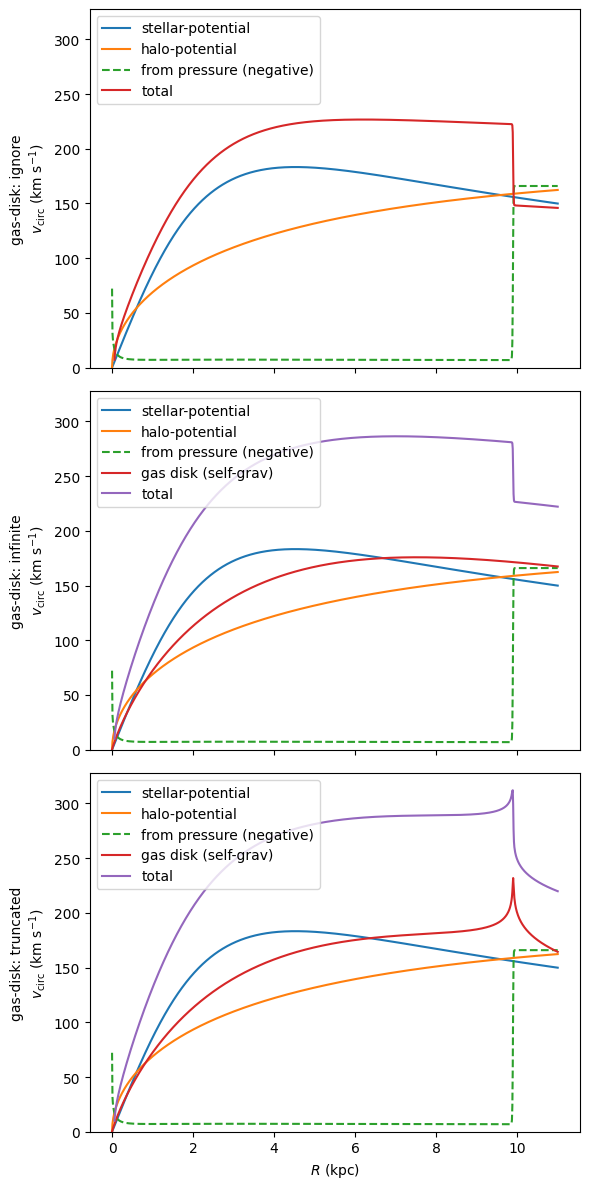

In [17]:
def compare_vrot_contributions(ax, cs_isothermal_kpc_per_kyr,
                               Rgas_truncation_radius = 9.9,
                               gas_disk_choice = 'ignore',
                               alpha = 0.005, R_vals = None,
                               R_g = 3.5, Mgas = 6.5e10,
                               star_forming_disk = None,
                               consider_pressure = True,
                               show_squared = False):

    _, gas_profile = ICs.get_sigma_gas_disk(
        Mgas = Mgas, R_g = R_g,
        Rgas_truncation_radius = Rgas_truncation_radius,
        alpha = alpha, force_unity_Sigma0 = False)

    def pressure_contributions(r_kpc, z_kpc):
        out = ICs.calc_vcirc2_presure_term(
            r_kpc, cs_isothermal_kpc_per_kyr = cs_isothermal_kpc_per_kyr,
            Sigma_gas_fn = gas_profile,
            static_components = [stellar_disk, halo],
            Rderiv_step_kpc = 1e-6).to('km**2/s**2').value
        return out

    nonstatic_pairs = []
    if consider_pressure:
        nonstatic_pairs.append(
            (pressure_contributions, 'from pressure (negative)'),
        )

    if gas_disk_choice == 'ignore':
        pass
    elif gas_disk_choice == 'infinite':
        nonstatic_pairs.append(
            (ICs.vcirc2_gas_builder(Mgas = Mgas, R_g = R_g, Rgas_truncation_radius = 0.0,
                                alpha = alpha),
             'gas disk (self-grav)')
        )
    elif gas_disk_choice == 'truncated':
        nonstatic_pairs.append(
            (ICs.vcirc2_gas_builder(Mgas = Mgas, R_g = R_g,
                                Rgas_truncation_radius = Rgas_truncation_radius,
                                alpha = alpha),
             'gas disk (self-grav)')
        )
    else:
        raise ValueError('invalid gas_disk_choice')

    if star_forming_disk is not None:
        nonstatic_pairs.append(
            (ICs.vcirc2_gas_builder(
                Mgas = star_forming_disk['Mtot'], 
                R_g = star_forming_disk['R_scale'],
                Rgas_truncation_radius = star_forming_disk['R_trunc'],
                alpha = star_forming_disk['alpha']
             ),
             'continuous star-forming disk (self-grav)')
        )

    ICs.plot_vcirc_contributions(ax, 
              comp_label_pairs = nonstatic_pairs,
              show_squared = show_squared,
              R_vals = R_vals)
    

fig,ax_arr = plt.subplots(3,1, figsize = (6,12), sharex=True, sharey = True)

for i, choice in enumerate(['ignore', 'infinite', 'truncated']):
    compare_vrot_contributions(ax_arr[i],
                               cs_isothermal_kpc_per_kyr = cs_isothermal_kpc_per_kyr,
                               Rgas_truncation_radius = 9.9,
                               gas_disk_choice = choice,
                               show_squared = False,
                               alpha = 0.005)
    ax_arr[i].set_ylabel(f'gas-disk: {choice}\n' + ax_arr[i].get_ylabel())
    ax_arr[i].legend(loc = 'upper left')

ax_arr[0].set_ylim(0.0, ax_arr[0].set_ylim()[1])
ax_arr[-1].set_xlabel(r"$R$ (kpc)")
fig.tight_layout()

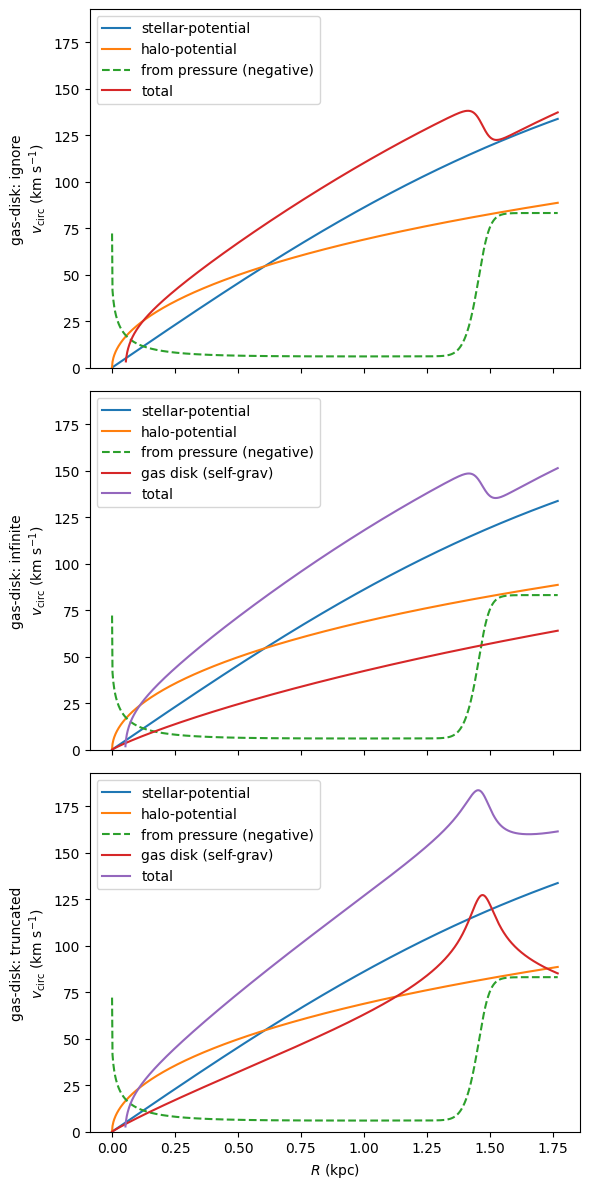

In [22]:
fig,ax_arr = plt.subplots(3,1, figsize = (6,12), sharex=True, sharey = True)

for i, choice in enumerate(['ignore', 'infinite', 'truncated']):
    compare_vrot_contributions(ax_arr[i],
                               cs_isothermal_kpc_per_kyr = cs_isothermal_kpc_per_kyr,
                               Rgas_truncation_radius = Rgas_truncation_radius,
                               gas_disk_choice = choice,
                               show_squared = False,
                               R_g = 5.4,
                               R_vals = np.linspace(0.000001, 1.77, num = 1000),
                               alpha = 0.02)
    ax_arr[i].set_ylabel(f'gas-disk: {choice}\n' + ax_arr[i].get_ylabel())
    ax_arr[i].legend(loc = 'upper left')

ax_arr[0].set_ylim(0.0, ax_arr[0].set_ylim()[1])
ax_arr[-1].set_xlabel(r"$R$ (kpc)")
fig.tight_layout()

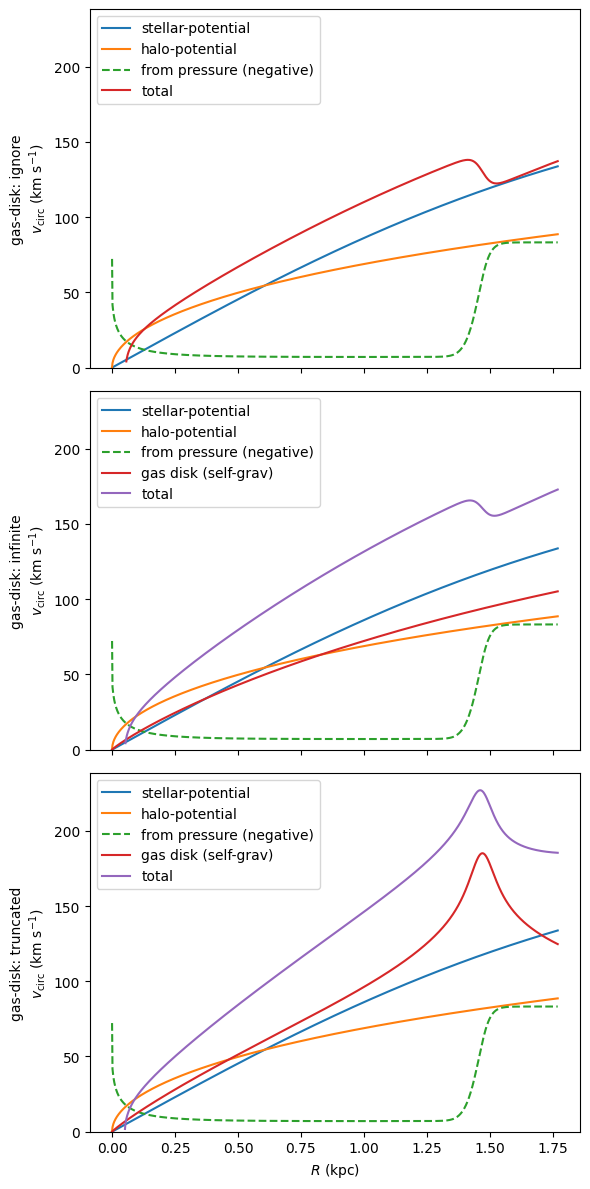

In [23]:
fig,ax_arr = plt.subplots(3,1, figsize = (6,12), sharex=True, sharey = True)

for i, choice in enumerate(['ignore', 'infinite', 'truncated']):
    compare_vrot_contributions(ax_arr[i],
                               cs_isothermal_kpc_per_kyr = cs_isothermal_kpc_per_kyr,
                               Rgas_truncation_radius = Rgas_truncation_radius,
                               gas_disk_choice = choice,
                               show_squared = False,
                               R_g = 3.5,
                               R_vals = np.linspace(0.000001, 1.77, num = 1000),
                               alpha = 0.02)
    ax_arr[i].set_ylabel(f'gas-disk: {choice}\n' + ax_arr[i].get_ylabel())
    ax_arr[i].legend(loc = 'upper left')

ax_arr[0].set_ylim(0.0, ax_arr[0].set_ylim()[1])
ax_arr[-1].set_xlabel(r"$R$ (kpc)")
fig.tight_layout()

In [13]:
def _get_star_particle_disk_props(Rgas_scale_length, total_SFR, k_s_power = 1.4,
                                  star_forming_duration = unyt.unyt_quantity(1.0, 'Gyr')):
    Mtot = star_forming_duration * total_SFR
    scale_length = Rgas_scale_length / k_s_power
    print(Mtot, scale_length)

_get_star_particle_disk_props(Rgas_scale_length= unyt.unyt_quantity(5.4, 'kpc'),
                              total_SFR = unyt.unyt_quantity(2, 'Msun/year'),
                              k_s_power = 1.4,
                              star_forming_duration = unyt.unyt_quantity(1.0, 'Gyr'))



1999999999.9999998 Msun 3.8571428571428577 kpc


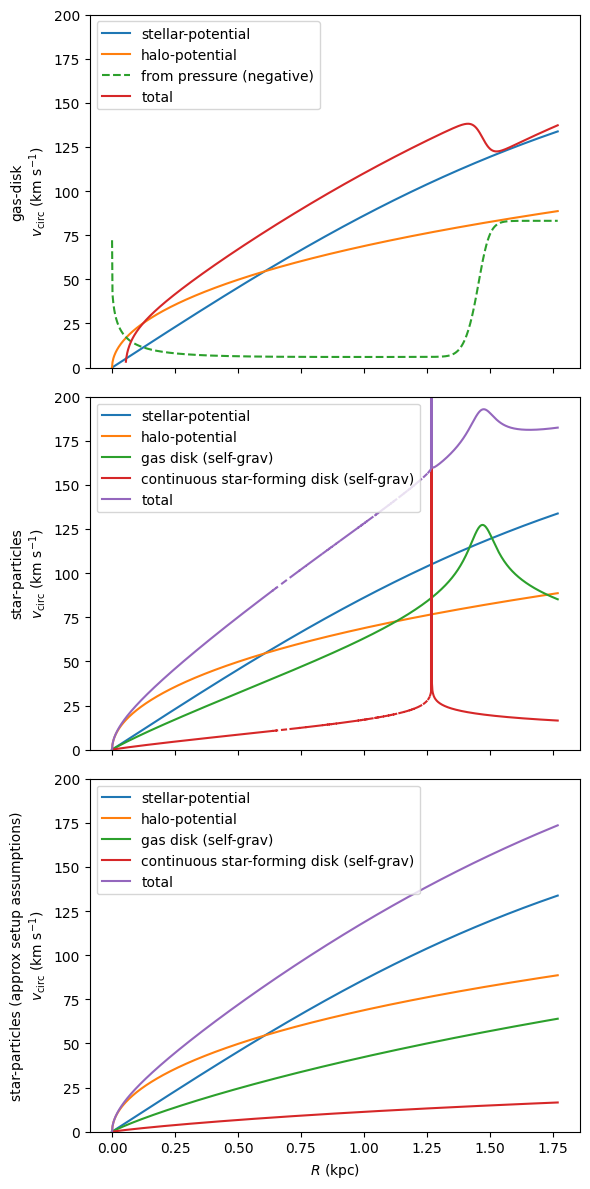

In [32]:
fig,ax_arr = plt.subplots(3,1, figsize = (6,12), sharex=True, sharey = True)

compare_vrot_contributions(
    ax_arr[0], cs_isothermal_kpc_per_kyr,
    Rgas_truncation_radius = Rgas_truncation_radius,
    gas_disk_choice = 'ignore',
    alpha = 0.02, R_vals = np.linspace(0.000001, 1.77, num = 1000),
    R_g = 5.4, Mgas = 6.5e10,
    star_forming_disk = None,
    consider_pressure = True,
    show_squared = False
)

ax_arr[0].set_ylabel(f'gas-disk\n' + ax_arr[0].get_ylabel())
ax_arr[0].legend(loc = 'upper left')

compare_vrot_contributions(
    ax_arr[1], cs_isothermal_kpc_per_kyr,
    Rgas_truncation_radius = Rgas_truncation_radius,
    gas_disk_choice = 'truncated',
    alpha = 0.02, R_vals = np.linspace(0.000001, 1.77, num = 1000),
    R_g = 5.4, Mgas = 6.5e10,
    star_forming_disk = {
        'Mtot': 2e9,
        'R_scale' : 3.8571428571428577,
        'alpha' : 0.00001,
        'R_trunc' : 1.27
    },  
    consider_pressure = False,
    show_squared = False
)

ax_arr[1].set_ylabel(f'star-particles\n' + ax_arr[1].get_ylabel())
ax_arr[1].legend(loc = 'upper left')

# now we crudely plot the assumptions made while setting up the problem...
# ---------------------------

compare_vrot_contributions(
    ax_arr[2], cs_isothermal_kpc_per_kyr,
    Rgas_truncation_radius = 20.0,
    gas_disk_choice = 'truncated',
    alpha = 0.02, R_vals = np.linspace(0.000001, 1.77, num = 1000),
    R_g = 5.4, Mgas = 6.5e10,
    star_forming_disk = {
        'Mtot': 2e9,
        'R_scale' : 3.8571428571428577,
        'alpha' : 0.02,
        'R_trunc' : 20.0
    },  
    consider_pressure = False,
    show_squared = False
)

ax_arr[2].set_ylabel(f'star-particles (approx setup assumptions)\n' + ax_arr[2].get_ylabel())
ax_arr[2].legend(loc = 'upper left')


ax_arr[0].set_ylim(0.0, 200.0)
ax_arr[-1].set_xlabel(r"$R$ (kpc)")
fig.tight_layout()

## Defunct Section

This was all experimentation that didn't really pan out

In [4]:
#this doesn't seem to work right!

from scipy import integrate

def tabulate(prof):
    # lets make a table of the integral of
    #    R * prof(R) / sqrt(R^2 - a^2), integrated with respect to R from a to infinity

    # in reality we only need to integrate up R_max
    R_max = prof.Rgas_truncation_radius + prof.alpha*38
    assert prof(R_max) == 0.0
    
    a_vals = np.arange(int((R_max * 100) + 0.5)) / 100.0
    integrals = np.empty_like(a_vals)
    integral_errs = np.empty_like(a_vals)
    
    
    if False:
        # using integration by parts, one can show that the integral is equal to
        def integrand(R, a):
            return -1 * prof.dSigma_dR(R) * np.sqrt(SQUARE(R) - SQUARE(a))
    else:
        def integrand(R, a):
            return prof(R) * R / np.sqrt(SQUARE(R) - SQUARE(a))
    
    for i,cur_a in enumerate(a_vals):
        integral, abserr = integrate.quad(integrand, a = cur_a, b = R_max, args = (cur_a,),
                                          epsabs = 1e-30)
        integrals[i] = integral
        integral_errs[i] = abserr
    
    a_step = a_vals[1] - a_vals[0]
    diffs = np.diff(integrals)
    dintegral_da = np.empty_like(a_vals)
    dintegral_da[1:-1] = (-0.5*diffs[:-1] + 0.5 * diffs[1:])/a_step
    dintegral_da[0] = (integrals[1]-integrals[0])/a_step
    dintegral_da[-1] = (integrals[-1]-integrals[-2])/a_step
    return a_vals, integrals, integral_errs, dintegral_da

class TruncatedDisk:
    def __init__(self, prof):
        self.prof = prof
        a_vals, integrals, integral_errs, dintegral_da = tabulate(prof)
        self.a_vals = a_vals
        self.integrals = integrals
        self.integral_errs = integral_errs
        self.dintegral_da = dintegral_da
        
    def vcirc2_km2Pers2(self, r_kpc):
        # from equation 2.157
        
        return_scalar = False
        if np.ndim(r_kpc) == 0:
            r_kpc = [r_kpc]
            return_scalar = True

        out = []
        if False:
            pass
        else:
            def integrand(a, R):
                deriv_of_inner_integral = np.interp(a, xp = self.a_vals, fp = self.dintegral_da)
                factor = a / np.sqrt(SQUARE(R) - SQUARE(a))
                return deriv_of_inner_integral * factor

            for cur_R in r_kpc:
                if True:
                    integral, abserr = integrate.quad(integrand, a = 0.0, b = cur_R, args = (cur_R,))
                else:
                    a_vals = np.linspace(0.0, cur_R *0.99999, num = 101)
                    integral = np.trapz(integrand(a_vals, cur_R), x = a_vals)
                out.append(-4*_GN * integral)

        out = unyt.unyt_array(out, 'kpc**2/kyr**2').to('km**2/s**2').ndview
        if return_scalar:
            return out[0]
        return out
gas_disk = TruncatedDisk(prof)
gas_disk.vcirc2_km2Pers2(8.0)

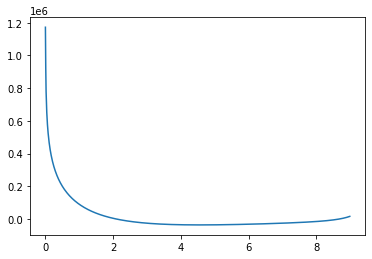

In [119]:
fig,ax = plt.subplots(1,1)
ax.plot(gas_disk.a_vals[:900], -1 *gas_disk.dintegral_da[:900])

In [6]:

"""
An instance of this class represents the family of homeoids, that
are equivalent to an axis-symmetric radial surface-density profile
for a razor-thin disk.

In more detail, homeoids are confocal oblate-spheroidal thin shells of 
constant density. If you consider them in (rcyl, z) space, they
correspond to ellipses. Just like a spherical shell, a given homeoid exerts
no gravitational force on contained points.

To represent a thin disk, we consider an infinitely flattened 
homeoid (the axial ratio tends towards zero)
"""
class ExpDiskHomeoidFamily:
    def __init__(self, fn, Sigma_factor = 1.0):
        """
        Parameters
        ----------
        fn : callable
            a function that takes a single argument `a` (the nominal
            semi-major axis of the homeoid). When multiplied by
            `-0.5 * pi * Sigma_factor`, it gives the nominal surface
            density contribution of that homeoid with semi-major axis
            and divided by the infintesimal thickness of the homeoid `da`.
            
        Note
        ----
        fn is not the same as the radial profile since a homeoid with semi-major
        axis `a` constributes mass at `R<a`
        """
        self._fn = fn
        self._Sigma_factor = Sigma_factor
        
    def dSigma_da_times_neghalfpi(self, a):
        fn = self._fn
        return fn(a) * self._Sigma_factor

    def dSigma_da(self, a):
        return self.dSigma_da_times_neghalfpi(a) * -(2.0 / np.pi)

    def dM_da(self, a):
        return -2 * np.pi * a * self.dSigma_da(a)

Text(0, 0.5, 'max $M/Mtot$')

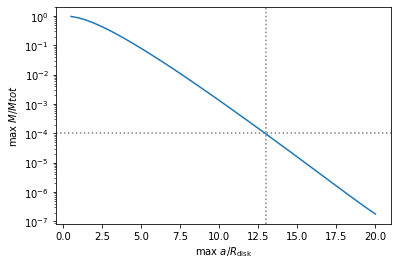

In [38]:
def tester(ax, nsteps_per_Rd = 100):
    M_d = 0.15 * 6.5e10 # Msun
    Rdisk = 3.5 #kpc
    
    # the central surface density:
    Sigma0 = M_d / (2 * np.pi * Rdisk**2)
    
    def fn(a_kpc):
        a_div_Rd = a_kpc/Rdisk
        return a_div_Rd * scipy.special.kn(0, (a_div_Rd==0.0) + a_div_Rd)
    expdiskhomeoidfamily = ExpDiskHomeoidFamily(fn = fn,
                                                Sigma_factor = Sigma0)
    
    max_adivRd_vals = np.linspace(0.0, 20.0, num = 41)[1:]
    
    nsteps_per_Rd = 100
    
    Mlist = []
    
    for max_a_div_Rd in max_adivRd_vals:
        nsteps = int(np.ceil(max_a_div_Rd*nsteps_per_Rd))
        a_vals = np.linspace(0.0, max_a_div_Rd * Rdisk, num = nsteps + 1)
        M = np.trapz(y = expdiskhomeoidfamily.dM_da(a_vals),
                     x = a_vals)
        Mlist.append(M)
    
    ax.plot(max_adivRd_vals, 1.0 - (np.array(Mlist)/M_d))
    print(ExpDiskHomeoidFamily)
    ax.set_yscale('log')
    
fig,ax = plt.subplots(1,1)
tester(ax, nsteps_per_Rd = 100)
ax.axhline(1e-4, color = 'gray', ls = ':')
ax.axvline(13, color = 'gray', ls = ':')
ax.set_xlabel(r'max $a/R_{\rm disk}$')
ax.set_ylabel(r'max $M/Mtot$')

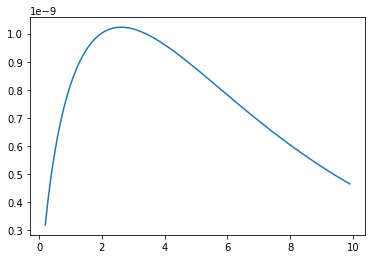

In [66]:



def do_integral(f, max_a, nsteps):
    
    if True:
        da = max_a / nsteps
        a_vals = np.arange(nsteps + 1) * da
        integrand = np.array([f(a) for a in a_vals])
        return np.trapz(integrand, dx = da)
    
# the potential of a thin exponential disk is:
# Phi(R,z) = - (4 * Sigma0 * G / R_d) * INT_0^INF da * arcsin_term * second_term
#
# -> G is the gravitational constant
# -> Sigma0 is the surface density at R = 0
# -> R_d is the scale-length of the disk
# -> a is an integration term
# -> arcsin_term is:
#     arcsin(2*a/[sqrt(z^2 + (a+R)^2) + sqrt(z^2 + (a-R)^2)])
# -> second_term is: a * K_0(a/R_d), where K_0 is a modified bessel function of the second kind
def phi_thinexp_disk(R, z, Rdisk, Sigma0 = 1.0, G = 1.0, nsteps_per_Rdisk = 100):
    z_square = z*z
    
    def fn(a_kpc):
        a_div_Rd = a_kpc/Rdisk
        return a_div_Rd * scipy.special.kn(0, (a_div_Rd==0.0) + a_div_Rd)
    ExpDiskHomeoidFamily = HomeoidFamily(fn = fn,
                                         Sigma_factor = Sigma0)
    
    def integrand(a):
        if z_square == 0 and (a >= R):
            # the argument of arcsine is 1
            arcsin_term = np.pi/2
        elif z_square == 0:
            arcsin_term = np.arcsin(a/R)
        else:
            sqrt_plus = np.sqrt(z_square + SQUARE(a+R))
            sqrt_minus = np.sqrt(z_square + SQUARE(a-R))
            arcsin_term = np.arcsin(2*a/(sqrt_plus + sqrt_minus))
        second_term = ExpDiskHomeoidFamily.dSigma_da_times_neghalfpi(a)
        return arcsin_term * second_term

    tmp = do_integral(f = integrand, max_a = 13 * Rdisk,
                      nsteps = int(13 * nsteps_per_Rdisk))
    return -(4 * G) * tmp






In [ ]:
GN = 4.49451e-18  # gravitational constant, kpc^3 / M_sun / kyr^2
Rdisk = 3.5 #kpc
Sigma0 = 0.15 * 6.5e10 / (2 * np.pi * Rdisk**2) # Msun/kpc^2

R_vals = np.linspace(0.1, 10.0, num = 101)


phi = np.array([phi_thinexp_disk(R, z = 0.0, Rdisk = Rdisk, Sigma0 = Sigma0, G = GN, 
                        nsteps_per_Rdisk = 300)
                for R in R_vals])
dphi_dR = (-0.5*phi[0:-2] + 0.5*phi[2:])/(R_vals[1]-R_vals[0])

fig,ax = plt.subplots(1,1)
ax.plot(R_vals[1:-1], dphi_dR)

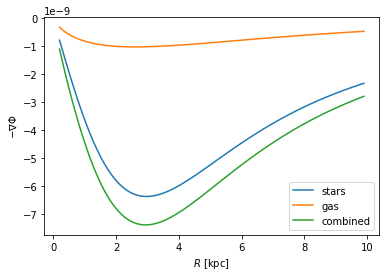

In [77]:

stellar_disk = MiyamotoNagaiDisk(mass_msun = 6.5e10, scale_radius_kpc = 3.5,
                                 scale_height_kpc = 0.7)
stellar_disk.potential(3.0, 0.0)


phi_stars = stellar_disk.potential(R_vals, z_kpc = 0.0)
dphi_dR_stars = (-0.5*phi_stars[0:-2] + 0.5*phi_stars[2:])/(R_vals[1]-R_vals[0])
dphi_dR_gas = (-0.5*phi[0:-2] + 0.5*phi[2:])/(R_vals[1]-R_vals[0])

fig,ax = plt.subplots(1,1)
ax.plot(R_vals[1:-1], -1*dphi_dR_stars, label = 'stars')
ax.plot(R_vals[1:-1], -1*dphi_dR_gas, label = 'gas')
ax.plot(R_vals[1:-1], -1*(dphi_dR_stars+dphi_dR_gas), label = 'combined')

ax.set_ylabel(r'$-\nabla \Phi$')
ax.set_xlabel(r'$R$ [kpc]')
ax.legend()

In [71]:
# https://ui.adsabs.harvard.edu/abs/2015MNRAS.448.2934S/abstract
_3MN_M_TABLE = np.array([
    [-0.0090,  0.0640, -0.1653,  0.1164,  1.9487],
    [ 0.0173, -0.0903,  0.0877,  0.2029, -1.3077],
    [ 0.0051,  0.0287, -0.0361, -0.0544,  0.2242],
])




class TripleMNDisk:
    
    def __init__(self, )

6.766635045184745e-08

In [102]:
class GasDisk:
    def __init__(self, scale_heigh_kpc):
        self.scale_height = scale_heigh_kpc
        
    def __call__(self, R_kpc, z_kpc):
        
        GN = 4.49451e-18  # gravitational constant, kpc^3 / M_sun / kyr^2
        Rdisk = 3.5 #kpc
        Sigma0 = 0.15 * 6.5e10 / (2 * np.pi * Rdisk**2) # Msun/kpc^2

        # we evaluate disks position
        potential_l = []
        weights_l = []
        
        num = 10
        concatenate = np.concatenate(
            [-1*np.linspace(0.0, 2*self.scale_height, num = num)[::-1],
             np.linspace(0.0, 2*self.scale_height, num = num)[1:]])
        print(z_heights)
        z_vals = np.abs(z_kpc - z_heights)
        
        for z_val in z_vals:
            potential_l.append(
                phi_thinexp_disk(R_kpc, z = z_val, Rdisk = Rdisk, Sigma0 = Sigma0, G = GN, 
                                 nsteps_per_Rdisk = 300)
            )
        potential_l = np.array(potential_l)
        weights = np.exp(-np.abs(z_heights)/self.scale_height)/(2*self.scale_height)
        print(weights)
        print(potential_l)
        
        return np.trapz(potential_l*weights, x = z_vals)
GasDisk(0.3)(0.1, 0.0)
        

[-0.6        -0.53333333 -0.46666667 -0.4        -0.33333333 -0.26666667
 -0.2        -0.13333333 -0.06666667 -0.          0.06666667  0.13333333
  0.2         0.26666667  0.33333333  0.4         0.46666667  0.53333333
  0.6       ]
[0.22555881 0.28168886 0.35178681 0.43932856 0.54865498 0.68518715
 0.8556952  1.06863398 1.33456234 1.66666667 1.33456234 1.06863398
 0.8556952  0.68518715 0.54865498 0.43932856 0.35178681 0.28168886
 0.22555881]
[-1.08276027e-08 -1.09856049e-08 -1.11492724e-08 -1.13190721e-08
 -1.14955552e-08 -1.16793870e-08 -1.18713928e-08 -1.20726351e-08
 -1.22845475e-08 -1.25090892e-08 -1.22845475e-08 -1.20726351e-08
 -1.18713928e-08 -1.16793870e-08 -1.14955552e-08 -1.13190721e-08
 -1.11492724e-08 -1.09856049e-08 -1.08276027e-08]


-1.2924697071141057e-25

In [194]:
_,sigma_gas_disk = get_sigma_gas_disk(Mgas = 0.15*6.5e10, R_g = 3.5,
                                      force_unity_Sigma0 = True,
                                      alpha = 0.01,
                                      Rgas_truncation_radius = 9.9)
sigma_gas_disk(3.5)

0.36787944117144233

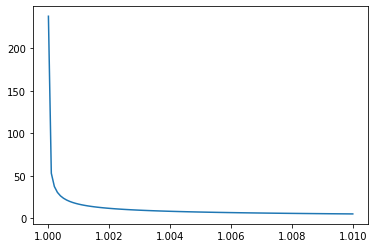

In [202]:
def homeoid_finding_integral(a, sigma_gas_disk, max_a = None):
    if max_a is None:
        max_a = 1.01 * a
    
    R_bounds = (a, max_a)
    
    #assert sigma_gas_disk(max_a) == 0.0
    R_vals = np.linspace(*R_bounds, num=101)
    R_vals[0] = np.sqrt(1.0e-5 + SQUARE(R_bounds[0]))
    numerator = R_vals * sigma_gas_disk(R_vals)
    denominator = np.sqrt(R_vals**2 - a**2)
    fig,ax = plt.subplots(1,1)
    ax.plot(R_vals, numerator/denominator)

homeoid_finding_integral(1.0, sigma_gas_disk, 1.01)

In [195]:
import

0.36787944117144233

In [ ]:
1-a

In [42]:
np.arcsin(1.5)

/home/mabruzzo/.pyenv/versions/3.7.2/envs/py37_new/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arcsin
  """Entry point for launching an IPython kernel.


nan

CPU times: user 16.7 s, sys: 18.7 ms, total: 16.8 s
Wall time: 16.8 s


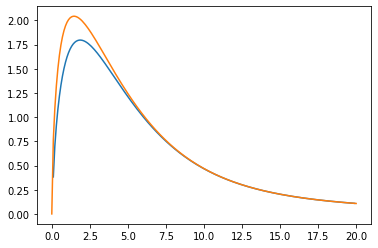

In [259]:
%%time
from scipy.integrate import trapezoid, fixed_quad, quad

def SQUARE(x): return x*x

def do_integral(f, max_a, nsteps, logspacing = False):
    
    if logspacing:
        a_vals = np.array([0.0] + np.geomspace(0.0001, max_a, num = nsteps).tolist())
        integrand = np.array([f(a) for a in a_vals])
        return trapezoid(integrand, x = a_vals)
    else:
        da = max_a / nsteps
        a_vals = np.arange(nsteps + 1) * da
        integrand = np.array([f(a) for a in a_vals])
        return trapezoid(integrand, dx = da)

# the potential of a thin exponential disk is:
# Phi(R,z) = - (4 * Sigma0 * G / R_d) * INT_0^INF da * arcsin_term * second_term
#
# -> G is the gravitational constant
# -> Sigma0 is the surface density at R = 0
# -> R_d is the scale-length of the disk
# -> a is an integration term
# -> arcsin_term is:
#     arcsin(2*a/[sqrt(z^2 + (a+R)^2) + sqrt(z^2 + (a-R)^2)])
# -> second_term is: a * K_0(a/R_d), where K_0 is a modified bessel function of the second kind
def phi_thinexp_disk(R, z, Rdisk, Sigma0 = 1.0, G = 1.0, nsteps = 100):
    z_square = z*z
    def integrand(a):
        if z_square == 0 and (a >= R):
            # the argument of arcsine is 1
            arcsin_term = np.pi/2
        elif z_square == 0:
            arcsin_term = np.arcsin(a/R)
        else:
            sqrt_plus = np.sqrt(z_square + SQUARE(a+R))
            sqrt_minus = np.sqrt(z_square + SQUARE(a-R))
            arcsin_term = np.arcsin(2*a/(sqrt_plus + sqrt_minus))
        if a != 0:
            second_term = a * scipy.special.kn(0,a/Rdisk)
        else:
            second_term = 0.0
        return arcsin_term * second_term

    tmp = do_integral(f = integrand, max_a = 20 * Rdisk, nsteps = nsteps)    
    return -(4 * Sigma0 * G/Rdisk) * tmp


# This is the radial derivative of the potential of a thin exponential disk:

def gr_thinexp_disk(R, z, Rdisk, Sigma0 = 1.0, G = 1.0, nsteps = 100):
    z_square = z*z
    
    if R == 0.0:
        return 0.0
    elif False:#z_square == 0:
        # in this case the arcsin term has a constant value for a >= R
        # -> thus, the derivative of the arcsin term is zero for a > R
        # -> consequently, we only need to consider the integral for 0 <= a <=R
        def integrand(a):
            # for z = 0 and a < R, arcsin_term is arcsin(a/R)
            # -> the derivative of that with respect to R is:
            if (a >= R):
                deriv_arcsin_term = 0.0
            else:
                deriv_arcsin_term = -a / np.sqrt(R**2 - a**2)
            #print(deriv_arcsin_term)
            if a != 0:
                second_term = a * scipy.special.kn(0,a/Rdisk)
            else:
                second_term = 0.0
            return deriv_arcsin_term * second_term
        tmp = do_integral(f = integrand,
                          max_a = R*0.9999999, # different from following branch
                          nsteps = nsteps)
        
    else:
        # integral of d/dR
        def integrand(a):
            
            sqrt_plus = np.sqrt(z_square + SQUARE(a+R))
            sqrt_minus = np.sqrt(z_square + SQUARE(a-R))
            numerator = -2 * a * ( ((a+R)/ sqrt_plus) - ((a-R)/ sqrt_minus) )            
            tmp_sum = sqrt_plus + sqrt_minus
            denom = SQUARE(tmp_sum) * np.sqrt(1.0 - 4 * SQUARE(a) / SQUARE(tmp_sum))
            
            deriv_arcsin_term = numerator / denom            
            if a != 0:
                second_term = a * scipy.special.kn(0,a/Rdisk)
            else:
                second_term = 0.0
            #print(deriv_arcsin_term,second_term)

            return deriv_arcsin_term * second_term
        
        
        tmp = do_integral(f = integrand, 
                          max_a = 20 * Rdisk, # different from other branch
                          logspacing = False,
                          nsteps = nsteps)
    return -(4 * Sigma0 * G/Rdisk) * tmp

R_vals = np.linspace(0,20, 201)

gr_thinexp_disk(R_vals[1], 0.00001, Rdisk = 2.5)



fig,ax = plt.subplots(1,1)

phi_vals = np.array([phi_thinexp_disk(R, 0.0001, Rdisk = 2.5, nsteps = 1001) for R in R_vals])
ax.plot(R_vals[1:-1], (-0.5*phi_vals[0:-2] + 0.5*phi_vals[2:])/(R_vals[1]-R_vals[0]))


ax.plot(R_vals, 
        [gr_thinexp_disk(R, 0.0001, Rdisk = 2.5, nsteps = 10001) for R in R_vals])
#ax.plot(R_vals, 
#        [gr_thinexp_disk(R, 0.0001, Rdisk = 2.5, nsteps = 10001) for R in R_vals])
#ax.plot(R_vals, 
#        [gr_thinexp_disk(R, 0.0001, Rdisk = 2.5, nsteps = 100001) for R in R_vals])
#ax.plot(R_vals, 
#        [gr_thinexp_disk(R, 0.0, Rdisk = 1.0, nsteps = 10001) for R in R_vals])


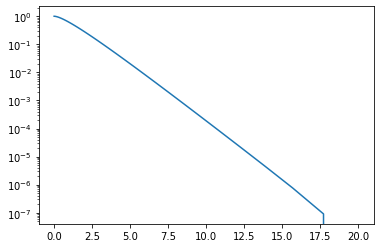

In [258]:
fig,ax = plt.subplots(1,1)

x = []
l = []

for xstop in np.geomspace(0.0001, 20.0, num = 101).tolist():
    xvals = np.linspace(0.0000001, xstop, num=100001)
    x.append(xstop)
    l.append(np.trapz(xvals * scipy.special.kn(0,xvals), x = xvals))

l = np.array(l)
ax.plot(x, l[-1] - l)
ax.set_yscale('log')


1.0


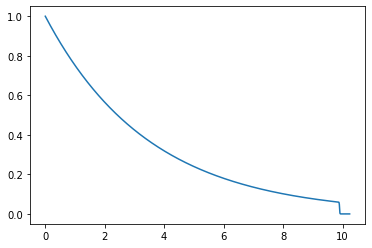

In [25]:


_,sigma_gas_disk,_ = get_sigma_gas_disk(Mgas = 0.15*6.5e10, R_g = 3.5,
                                      force_unity_Sigma0 = True,
                                      alpha = None,
                                      Rgas_truncation_radius = 9.9)

fig,ax = plt.subplots(1,1)
R = np.linspace(0.0, 10.24, num = 1001)
print(sigma_gas_disk(0.0))
ax.plot(R, sigma_gas_disk(R))
#ax.set_yscale('log')

/home/mabruzzo/.pyenv/versions/3.7.2/envs/py37_new/lib/python3.7/site-packages/galpy/potential/RazorThinExponentialDiskPotential.py:115: RuntimeWarning: invalid value encountered in multiply
  return -2.*numpy.pi*y*(special.i0(y)*special.k0(y)-special.i1(y)*special.k1(y))

/home/mabruzzo/.pyenv/versions/3.7.2/envs/py37_new/lib/python3.7/site-packages/galpy/potential/AnyAxisymmetricRazorThinDiskPotential.py:134: RuntimeWarning: invalid value encountered in double_scalars
  faRoveraRz= 4*a*R/aRz

/home/mabruzzo/.pyenv/versions/3.7.2/envs/py37_new/lib/python3.7/site-packages/galpy/potential/AnyAxisymmetricRazorThinDiskPotential.py:139: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return 2*(integrate.quad(rforceint,0,2*R,points=[R])[0]

/home/mabruzzo/.pyenv/versions/3.7.2/envs/py37_new/lib/python3.7/site-packages/galpy/potential/AnyAxisymmetricRazorThinDiskPotential.py:138: RuntimeWarning: invalid value encountered in double_s

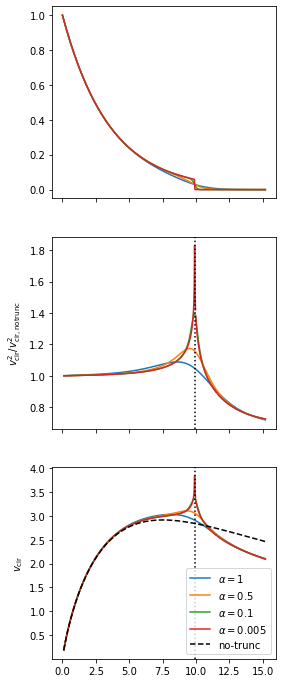

In [28]:




def make_plot(Rgas_truncation_radius = 9.9):
    
    coarse_stop = Rgas_truncation_radius - 0.3
    R = np.array(np.linspace(0.0, coarse_stop, num = int(coarse_stop *10 + 1)).tolist() +
                 np.linspace(coarse_stop, Rgas_truncation_radius+0.3, num = 61)[1:].tolist() +
                 np.linspace(Rgas_truncation_radius+0.3, Rgas_truncation_radius + 5.3, num = 51)[1:].tolist())
    ordinary_vcirc2 = np.square(
        RazorThinExponentialDiskPotential(hr = 3.5).vcirc(R))

    fig, ax_arr = plt.subplots(3,1, sharex = True, figsize = (4,12))

    for alpha in [1, 0.5,0.1,0.005]:
        _,sigma_gas_disk,_ = get_sigma_gas_disk(Mgas = 0.15*6.5e10, R_g = 3.5,
                                              force_unity_Sigma0 = True,
                                              alpha = alpha,
                                              Rgas_truncation_radius = Rgas_truncation_radius)
        ax_arr[0].plot(R, sigma_gas_disk(R),
                       label = f'$\\alpha = {alpha!r}$')
    
        tmp = AnyAxisymmetricRazorThinDiskPotential(surfdens=sigma_gas_disk)
        v_circ = [tmp.vcirc(e) for e in R]
        ax_arr[1].plot(R, np.square(v_circ)/ordinary_vcirc2,
                   label = f'$\\alpha = {alpha!r}$')
        ax_arr[2].plot(R, v_circ,
                   label = f'$\\alpha = {alpha!r}$')
    ax_arr[2].plot(R, np.sqrt(ordinary_vcirc2),
                   label = f'no-trunc', color = 'k', ls = '--')
    ax_arr[1].set_ylabel(r'$v_{\rm cir}^2 / v_{\rm cir, notrunc}^2$')
    ax_arr[2].set_ylabel(r'$v_{\rm cir}$')
    ax_arr[2].legend()
    ax_arr[1].axvline(Rgas_truncation_radius, color = 'k', ls = ':')
    ax_arr[2].axvline(Rgas_truncation_radius, color = 'k', ls = ':')

make_plot(Rgas_truncation_radius = 9.9)

/home/mabruzzo/.pyenv/versions/3.7.2/envs/py37_new/lib/python3.7/site-packages/galpy/potential/RazorThinExponentialDiskPotential.py:115: RuntimeWarning: invalid value encountered in multiply
  return -2.*numpy.pi*y*(special.i0(y)*special.k0(y)-special.i1(y)*special.k1(y))

/home/mabruzzo/.pyenv/versions/3.7.2/envs/py37_new/lib/python3.7/site-packages/galpy/potential/AnyAxisymmetricRazorThinDiskPotential.py:134: RuntimeWarning: invalid value encountered in double_scalars
  faRoveraRz= 4*a*R/aRz

/home/mabruzzo/.pyenv/versions/3.7.2/envs/py37_new/lib/python3.7/site-packages/galpy/potential/AnyAxisymmetricRazorThinDiskPotential.py:139: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return 2*(integrate.quad(rforceint,0,2*R,points=[R])[0]

/home/mabruzzo/.pyenv/versions/3.7.2/envs/py37_new/lib/python3.7/site-packages/galpy/potential/AnyAxisymmetricRazorThinDiskPotential.py:138: RuntimeWarning: invalid value encountered in double_s

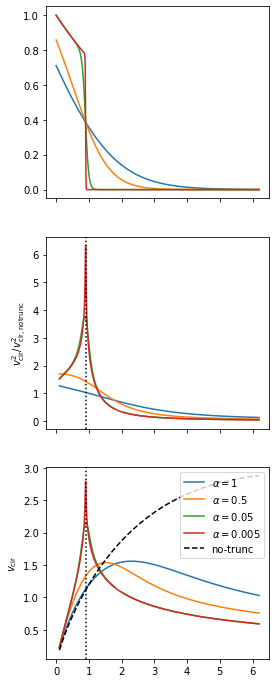

In [211]:
make_plot(Rgas_truncation_radius = 0.9)

In [23]:
from galpy.potential import (
    MiyamotoNagaiPotential, MN3ExponentialDiskPotential,
    RazorThinExponentialDiskPotential,
    DoubleExponentialDiskPotential,
    AnyAxisymmetricRazorThinDiskPotential
)
import galpy
from galpy.util import conversion
from astropy import units

In [81]:
mp= MiyamotoNagaiPotential(amp=5*10**10*units.Msun,a=3.*units.kpc,b=300.*units.pc)


In [ ]:
razorthin = AnyAxisymmetricRazorThinDiskPotential

In [15]:
mp= MiyamotoNagaiPotential(amp=5*10**10,a=3.,b=0.3)
conversion.velocity_in_kmsMyr(mp.vcirc(10.0))

TypeError: force_in_kmsMyr() missing 1 required positional argument: 'ro'

In [8]:
6.5e10 * u.Msun

<Quantity 6.5e+10 solMass>

NameError: name 'units' is not defined

In [58]:
stellar_disk.Rforce(0.1 * units.kpc, z = 0.0 * units.kpc)

<Quantity -0.87124855 km / (Myr s)>

In [78]:
def build_gas_disk(disk_mass, z_disk, r_disk, kind = 'double_exponential'):
    Sigma0 = disk_mass / (2 * np.pi * r_disk**2)
    if kind == 'double_exponential':
        # The density formula is
        #    rho(R, z) = Sigma0 * exp(-(abs(z)/z_disk) - (R/r_disk)) / (2 * z_disk)
        # If we integrate over z, (from -infinity to infinity), the radial surface
        # density profile is
        #    Sigma(R) = Sigma0 * exp(-(R/r_disk))
        # Clearly Sigma0 is the central surface density
        #
        # Integrating over the area of the disk tells us that
        #    disk_mass = Sigma0 * 2 * pi * r_disk**2
        # The amplitude expected by DoubleExponentialDiskPotential is
        #    rho(R,z) = Amp * exp(-(abs(z)/z_disk) - (R/r_disk))
        amp = Sigma0 / (2.0 * z_disk)
        print(amp)
        return DoubleExponentialDiskPotential(
            amp = amp, hr = r_disk, hz = z_disk)
    elif kind == 'razor_exponential':
        # Sigma(R) = Sigma0 * exp(-(R/r_disk))
        Sigma0 = disk_mass / (2 * np.pi * r_disk**2)
        return RazorThinExponentialDiskPotential(amp = Sigma0, hr = r_disk)
    elif kind == 'MN3':
        amp = Sigma0 / (2.0 * z_disk)
        return MN3ExponentialDiskPotential(
            amp = amp, hr = r_disk, hz = z_disk, sech = False,
            posdens = False)
    else:
        raise ValueError("unrecognized kind")

def build_combined_potential(stellar_disk_mass, *, z_gas_disk, r_gas_disk,
                             gas_kind = 'double_exponential'):
    stellar_disk = MiyamotoNagaiPotential(
        amp = stellar_disk_mass,
        a = 2.5 * units.kpc,
        b = 0.7 * units.kpc,
    )
    if gas_kind is None:
        return stellar_disk
    gas_disk = build_gas_disk(
            disk_mass = 0.15 * stellar_disk_mass,
            z_disk = z_gas_disk, r_disk = r_gas_disk,
            kind = gas_kind)
    return stellar_disk + gas_disk


my_stellar_disk_mass = 6.5e10 * units.Msun
disk_potential = build_combined_potential(
    my_stellar_disk_mass, z_gas_disk = 0.7 *units.kpc,
    r_gas_disk = 3.5 *units.kpc,
    gas_kind = 'razor_exponential')

In [35]:
(gas_disk.Rforce(0.1 * units.kpc, z = 0.1 * units.kpc, use_physical = True) + 
 stellar_disk.Rforce(0.1 * units.kpc, z = 0.1 * units.kpc, use_physical = True))

<Quantity -0.94016479 km / (Myr s)>

In [42]:
galpy.potential.evaluateRforces((gas_disk + stellar_disk),
                                0.1 * units.kpc, z = 0.1 * units.kpc)

<Quantity -0.94016479 km / (Myr s)>

In [10]:
disk_potential[0].zforce(0.001*units.kpc, z = 0.1 * units.kpc)

<Quantity -3.13091964 km / (Myr s)>

In [11]:
disk_potential[0].zforce(0.01*units.kpc, z = 0.1 * units.kpc)

<Quantity -3.13070821 km / (Myr s)>

In [79]:
build_combined_potential(my_stellar_disk_mass,
                              z_gas_disk = 0.7 *units.kpc,
                              r_gas_disk = 3.5 *units.kpc,
                              gas_kind = 'MN3')

180963346.372709 solMass / kpc3
/home/mabruzzo/.pyenv/versions/3.7.2/envs/py37_new/lib/python3.7/site-packages/galpy/potential/DoubleExponentialDiskPotential.py:17: RuntimeWarning: overflow encountered in sinh
  return (numpy.sinh(numpy.pi*numpy.sinh(t))

/home/mabruzzo/.pyenv/versions/3.7.2/envs/py37_new/lib/python3.7/site-packages/galpy/potential/DoubleExponentialDiskPotential.py:18: RuntimeWarning: overflow encountered in cosh
  +numpy.pi*t*numpy.cosh(t))/(numpy.cosh(numpy.pi*numpy.sinh(t))+1)

/home/mabruzzo/.pyenv/versions/3.7.2/envs/py37_new/lib/python3.7/site-packages/galpy/potential/DoubleExponentialDiskPotential.py:18: RuntimeWarning: invalid value encountered in true_divide
  +numpy.pi*t*numpy.cosh(t))/(numpy.cosh(numpy.pi*numpy.sinh(t))+1)

90481673.1863545 solMass / kpc3
90481673.1863545 solMass / kpc3


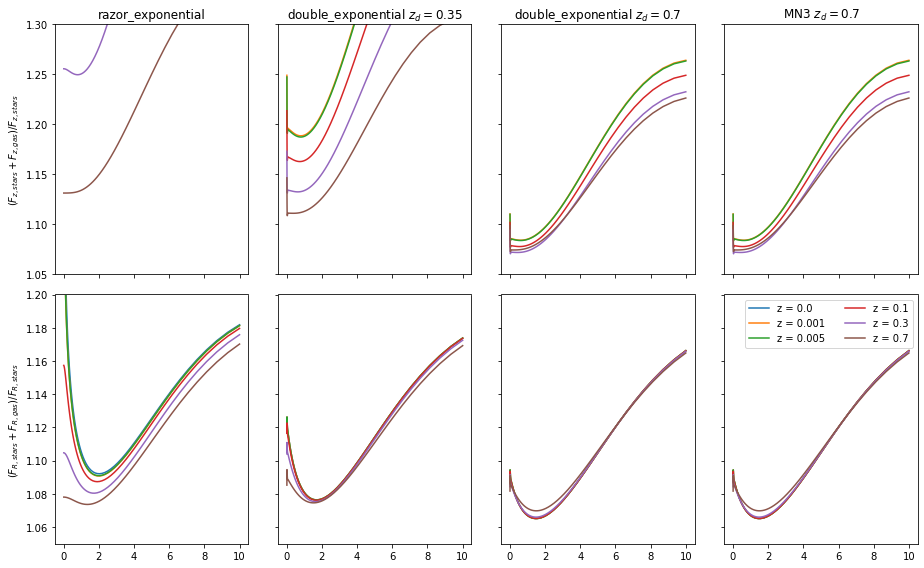

In [91]:


def plot_force(ax, potentials, R_vals, z, *, kind, ref_potential = None, **kwargs):
    if kind == 'z':
        fn = galpy.potential.evaluatezforces
    elif kind == 'R':
        fn = galpy.potential.evaluateRforces
    force = [fn(potentials, R, z).value for R in R_vals]
    
    if ref_potential is None:
        y = force
    else:
        ref_force = [fn(ref_potential, R, z).value for R in R_vals]
        y = np.array(force) / np.array(ref_force)
        
              
    ax.plot(R_vals, y, **kwargs)




pairs = [
    ('razor_exponential', 
     build_combined_potential(my_stellar_disk_mass,
                              z_gas_disk = 0.7 *units.kpc,
                              r_gas_disk = 3.5 *units.kpc,
                              gas_kind = 'razor_exponential')
    ),
    
    (r'double_exponential $z_{d} = 0.35$',
     build_combined_potential(my_stellar_disk_mass,
                              z_gas_disk = 0.35 *units.kpc,
                              r_gas_disk = 3.5 *units.kpc,
                              gas_kind = 'double_exponential')
    ),
    (r'double_exponential $z_{d} = 0.7$',
     build_combined_potential(my_stellar_disk_mass,
                              z_gas_disk = 0.7 *units.kpc,
                              r_gas_disk = 3.5 *units.kpc,
                              gas_kind = 'double_exponential')
    ),
    (r'MN3 $z_{d} = 0.7$',
     build_combined_potential(my_stellar_disk_mass,
                              z_gas_disk = 0.7 *units.kpc,
                              r_gas_disk = 3.5 *units.kpc,
                              gas_kind = 'double_exponential')
    ),
]

fig, ax_arr = plt.subplots(2,len(pairs), figsize = (1 + 3 *len(pairs), 8), sharey = 'row', sharex = True)



Rvals = np.geomspace(0.01, 10.0, num = 101) * units.kpc
for i, (potential_name, disk_potential) in enumerate(pairs):
    ax = ax_arr[0,i]

    stellar_potential = build_combined_potential(
        my_stellar_disk_mass,
        z_gas_disk = 0.7 *units.kpc,
        r_gas_disk = 3.5 *units.kpc,
        gas_kind = None)
    
    ax_arr[0,i].set_title(potential_name)
    
    for j, curz in enumerate([0.0, 0.001, 0.005, 0.1, 0.3, 0.7, 1.0, 2.0, 5.0][:6]):
        color = f'C{j}'
        if curz != 0:
            plot_force(ax_arr[0,i], disk_potential, Rvals,
                       z = curz * units.kpc, kind = 'z', label = f'z = {curz!r}',
                       ref_potential = stellar_potential, color = color)
        plot_force(ax_arr[1,i], disk_potential, Rvals,
                   z = curz * units.kpc, kind = 'R', label = f'z = {curz!r}',
                   ref_potential = stellar_potential, color = color)
        

ax_arr[0,0].set_ylabel(r'$(F_{z,stars} + F_{z,gas})/F_{z,stars}$')
ax_arr[1,0].set_ylabel(r'$(F_{R,stars} + F_{R,gas})/F_{R,stars}$')
ax_arr[0,0].set_ylim(1.05,1.3)
ax_arr[1,0].set_ylim(1.05,1.2)
ax_arr[1,-1].legend(ncol = 2)
fig.tight_layout()

3166858561.5224075 solMass / kpc3
/home/mabruzzo/.pyenv/versions/3.7.2/envs/py37_new/lib/python3.7/site-packages/galpy/potential/DoubleExponentialDiskPotential.py:17: RuntimeWarning: overflow encountered in sinh
  return (numpy.sinh(numpy.pi*numpy.sinh(t))

/home/mabruzzo/.pyenv/versions/3.7.2/envs/py37_new/lib/python3.7/site-packages/galpy/potential/DoubleExponentialDiskPotential.py:18: RuntimeWarning: overflow encountered in cosh
  +numpy.pi*t*numpy.cosh(t))/(numpy.cosh(numpy.pi*numpy.sinh(t))+1)

/home/mabruzzo/.pyenv/versions/3.7.2/envs/py37_new/lib/python3.7/site-packages/galpy/potential/DoubleExponentialDiskPotential.py:18: RuntimeWarning: invalid value encountered in true_divide
  +numpy.pi*t*numpy.cosh(t))/(numpy.cosh(numpy.pi*numpy.sinh(t))+1)

633371712.3044815 solMass / kpc3
633371712.3044815 solMass / kpc3


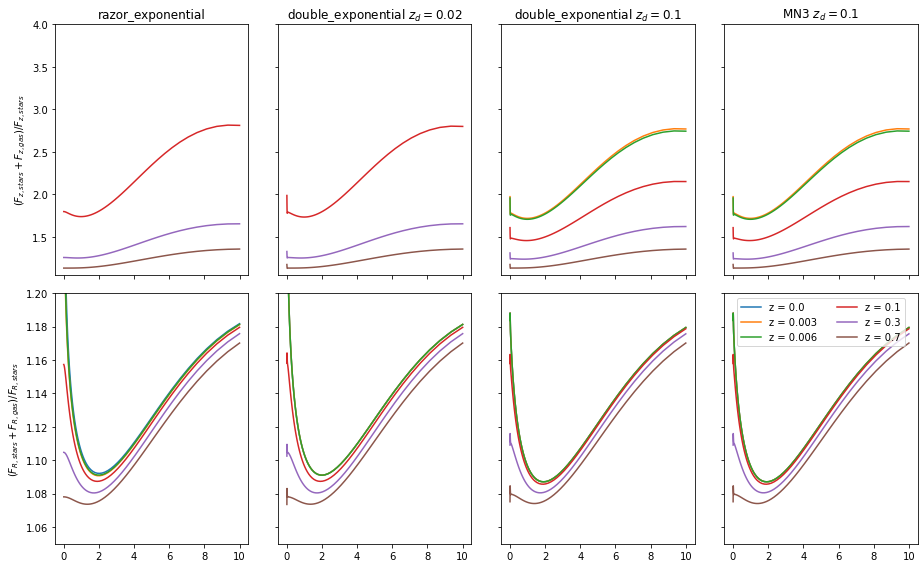

In [110]:


def plot_force(ax, potentials, R_vals, z, *, kind, ref_potential = None, **kwargs):
    if kind == 'z':
        fn = galpy.potential.evaluatezforces
    elif kind == 'R':
        fn = galpy.potential.evaluateRforces
    force = [fn(potentials, R, z).value for R in R_vals]
    
    if ref_potential is None:
        y = force
    else:
        ref_force = [fn(ref_potential, R, z).value for R in R_vals]
        y = np.array(force) / np.array(ref_force)
        
              
    ax.plot(R_vals, y, **kwargs)




pairs = [
    ('razor_exponential', 
     build_combined_potential(my_stellar_disk_mass,
                              z_gas_disk = 0.7 *units.kpc,
                              r_gas_disk = 3.5 *units.kpc,
                              gas_kind = 'razor_exponential')
    ),
    
    (r'double_exponential $z_{d} = 0.02$',
     build_combined_potential(my_stellar_disk_mass,
                              z_gas_disk = 0.02 *units.kpc,
                              r_gas_disk = 3.5 *units.kpc,
                              gas_kind = 'double_exponential')
    ),
    (r'double_exponential $z_{d} = 0.1$',
     build_combined_potential(my_stellar_disk_mass,
                              z_gas_disk = 0.1 *units.kpc,
                              r_gas_disk = 3.5 *units.kpc,
                              gas_kind = 'double_exponential')
    ),
    (r'MN3 $z_{d} = 0.1$',
     build_combined_potential(my_stellar_disk_mass,
                              z_gas_disk = 0.1 *units.kpc,
                              r_gas_disk = 3.5 *units.kpc,
                              gas_kind = 'double_exponential')
    ),
]

fig, ax_arr = plt.subplots(2,len(pairs), figsize = (1 + 3 *len(pairs), 8), sharey = 'row', sharex = True)



Rvals = np.geomspace(0.01, 10.0, num = 101) * units.kpc
for i, (potential_name, disk_potential) in enumerate(pairs):
    ax = ax_arr[0,i]

    stellar_potential = build_combined_potential(
        my_stellar_disk_mass,
        z_gas_disk = 0.7 *units.kpc,
        r_gas_disk = 3.5 *units.kpc,
        gas_kind = None)
    
    ax_arr[0,i].set_title(potential_name)
    
    for j, curz in enumerate([0.0, 0.003, 0.006, 0.1, 0.3, 0.7, 1.0, 2.0, 5.0][:6]):
        color = f'C{j}'
        if curz != 0:
            plot_force(ax_arr[0,i], disk_potential, Rvals,
                       z = curz * units.kpc, kind = 'z', label = f'z = {curz!r}',
                       ref_potential = stellar_potential, color = color)
        plot_force(ax_arr[1,i], disk_potential, Rvals,
                   z = curz * units.kpc, kind = 'R', label = f'z = {curz!r}',
                   ref_potential = stellar_potential, color = color)
        

ax_arr[0,0].set_ylabel(r'$(F_{z,stars} + F_{z,gas})/F_{z,stars}$')
ax_arr[1,0].set_ylabel(r'$(F_{R,stars} + F_{R,gas})/F_{R,stars}$')
ax_arr[0,0].set_ylim(1.05,4)
ax_arr[1,0].set_ylim(1.05,1.2)
ax_arr[1,-1].legend(ncol = 2)
fig.tight_layout()

In [92]:
import ctypes

In [93]:
l = [1.603628e+07, 1.603436e+07, 1.603053e+07, 1.602478e+07, 1.601713e+07, 1.600756e+07, 1.599609e+07, 1.598271e+07, 1.596745e+07, 1.595029e+07, 1.593126e+07, 1.591035e+07, 1.588757e+07, 1.586294e+07, 1.583647e+07, 1.580816e+07, 1.577803e+07, 1.574609e+07, 1.571236e+07, 1.567683e+07, 1.563954e+07, 1.560050e+07, 1.555972e+07, 1.551722e+07, 1.547301e+07, 1.542711e+07, 1.537955e+07, 1.533034e+07, 1.527949e+07, 1.522704e+07, 1.517300e+07, 1.511739e+07, 1.506023e+07, 1.500155e+07, 1.494137e+07, 1.487971e+07, 1.481660e+07, 1.475205e+07, 1.468610e+07, 1.461877e+07, 1.455008e+07, 1.448006e+07, 1.440874e+07, 1.433614e+07, 1.426229e+07, 1.418721e+07, 1.411094e+07, 1.403350e+07, 1.395492e+07, 1.387522e+07, 1.379444e+07, 1.371260e+07, 1.362974e+07, 1.354587e+07, 1.346104e+07, 1.337526e+07, 1.328857e+07, 1.320100e+07, 1.311258e+07, 1.302332e+07, 1.293328e+07, 1.284247e+07, 1.275092e+07, 1.265866e+07, 1.256572e+07, 1.247214e+07, 1.237793e+07, 1.228314e+07, 1.218778e+07, 1.209189e+07, 1.199549e+07, 1.189862e+07, 1.180130e+07, 1.170356e+07, 1.160544e+07, 1.150694e+07, 1.140811e+07, 1.130898e+07, 1.120956e+07, 1.110989e+07, 1.100999e+07, 1.090988e+07, 1.080961e+07, 1.070918e+07, 1.060863e+07, 1.050799e+07, 1.040726e+07, 1.030649e+07, 1.020570e+07, 1.010491e+07, 1.000413e+07, 9.903408e+06, 9.802751e+06, 9.702186e+06, 9.601735e+06, 9.501419e+06, 9.401260e+06, 9.301279e+06, 9.201497e+06, 9.101933e+06, 9.002608e+06, 8.903541e+06, 8.804752e+06, 8.706257e+06, 8.608077e+06, 8.510228e+06, 8.412728e+06, 8.315594e+06, 8.218843e+06, 8.122490e+06, 8.026552e+06, 7.931044e+06, 7.835980e+06, 7.741375e+06, 7.647243e+06, 7.553598e+06, 7.460453e+06, 7.367821e+06, 7.275714e+06, 7.184145e+06, 7.093124e+06, 7.002664e+06, 6.912774e+06, 6.823466e+06, 6.734749e+06, 6.646633e+06, 6.559128e+06, 6.472242e+06, 6.385983e+06, 6.300360e+06, 6.215381e+06, 6.131053e+06, 6.047382e+06, 5.964376e+06, 5.882041e+06, 5.800383e+06, 5.719407e+06, 5.639119e+06, 5.559524e+06, 5.480625e+06, 5.402429e+06, 5.324938e+06, 5.248156e+06, 5.172087e+06, 5.096734e+06, 5.022098e+06, 4.948184e+06, 4.874992e+06, 4.802526e+06, 4.730786e+06, 4.659774e+06, 4.589490e+06, 4.519937e+06, 4.451114e+06, 4.383021e+06, 4.315660e+06, 4.249029e+06, 4.183128e+06, 4.117956e+06, 4.053514e+06, 3.989799e+06, 3.926811e+06, 3.864548e+06, 3.803008e+06, 3.742190e+06, 3.682091e+06, 3.622710e+06, 3.564044e+06, 3.506091e+06, 3.448847e+06, 3.392310e+06, 3.336477e+06, 3.281344e+06, 3.226909e+06, 3.173168e+06, 3.120117e+06, 3.067753e+06, 3.016072e+06, 2.965069e+06, 2.914742e+06, 2.865084e+06, 2.816093e+06, 2.767764e+06, 2.720093e+06, 2.673074e+06, 2.626703e+06, 2.580976e+06, 2.535887e+06, 2.491432e+06, 2.447605e+06, 2.404402e+06, 2.361818e+06, 2.319846e+06, 2.278483e+06, 2.237723e+06, 2.197560e+06, 2.157989e+06, 2.119005e+06, 2.080601e+06, 2.042774e+06, 2.005516e+06, 1.968823e+06, 1.932689e+06, 1.897109e+06, 1.862075e+06, 1.827584e+06, 1.793629e+06, 1.760205e+06, 1.727306e+06, 1.694926e+06, 1.663059e+06, 1.631700e+06, 1.600843e+06, 1.570483e+06, 1.540613e+06, 1.511228e+06, 1.482322e+06, 1.453889e+06, 1.425925e+06, 1.398422e+06, 1.371376e+06, 1.344780e+06, 1.318630e+06, 1.292919e+06, 1.267642e+06, 1.242794e+06, 1.218369e+06, 1.194360e+06, 1.170764e+06, 1.147574e+06, 1.124785e+06, 1.102392e+06, 1.080388e+06, 1.058770e+06, 1.037531e+06, 1.016667e+06, 9.961711e+05, 9.760395e+05, 9.562665e+05, 9.368472e+05, 9.177763e+05, 8.990489e+05, 8.806599e+05, 8.626044e+05, 8.448775e+05, 8.274743e+05, 8.103900e+05, 7.936197e+05, 7.771588e+05, 7.610025e+05, 7.451461e+05, 7.295851e+05, 7.143149e+05, 6.993310e+05, 6.846288e+05, 6.702040e+05, 6.560522e+05, 6.421690e+05, 6.285501e+05, 6.151914e+05, 6.020885e+05, 5.892374e+05, 5.766339e+05, 5.642740e+05, 5.521537e+05, 5.402691e+05, 5.286161e+05, 5.171909e+05, 5.059898e+05, 4.950089e+05, 4.842445e+05, 4.736930e+05, 4.633506e+05, 4.532139e+05, 4.432792e+05, 4.335431e+05, 4.240022e+05, 4.146529e+05, 4.054921e+05, 3.965163e+05, 3.877222e+05, 3.791068e+05, 3.706667e+05, 3.623989e+05, 3.543002e+05, 3.463677e+05, 3.385983e+05, 3.309890e+05, 3.235370e+05, 3.162394e+05, 3.090933e+05, 3.020959e+05, 2.952446e+05, 2.885366e+05, 2.819692e+05, 2.755398e+05, 2.692458e+05, 2.630847e+05, 2.570540e+05, 2.511512e+05, 2.453739e+05, 2.397197e+05, 2.341862e+05, 2.287711e+05, 2.234722e+05, 2.182872e+05, 2.132139e+05, 2.082501e+05, 2.033937e+05, 1.986427e+05, 1.939948e+05, 1.894482e+05, 1.850009e+05, 1.806507e+05, 1.763959e+05, 1.722346e+05, 1.681648e+05, 1.641848e+05, 1.602927e+05, 1.564868e+05, 1.527653e+05, 1.491265e+05, 1.455688e+05, 1.420905e+05, 1.386900e+05, 1.353657e+05, 1.321160e+05, 1.289395e+05, 1.258345e+05, 1.227996e+05, 1.198334e+05, 1.169345e+05, 1.141014e+05, 1.113327e+05, 1.086272e+05, 1.059834e+05, 1.034002e+05, 1.008762e+05, 9.841011e+04, 9.600078e+04, 9.364699e+04, 9.134756e+04, 8.910131e+04, 8.690713e+04, 8.476388e+04, 8.267048e+04, 8.062585e+04, 7.862894e+04, 7.667872e+04, 7.477417e+04, 7.291430e+04, 7.109815e+04, 6.932475e+04, 6.759316e+04, 6.590249e+04, 6.425181e+04, 6.264026e+04, 6.106697e+04, 5.953110e+04, 5.803180e+04, 5.656828e+04, 5.513974e+04, 5.374539e+04, 5.238448e+04, 5.105624e+04, 4.975996e+04, 4.849491e+04, 4.726038e+04, 4.605570e+04, 4.488017e+04, 4.373315e+04, 4.261398e+04, 4.152203e+04, 4.045669e+04, 3.941733e+04, 3.840337e+04, 3.741423e+04, 3.644933e+04, 3.550812e+04, 3.459004e+04, 3.369457e+04, 3.282119e+04, 3.196937e+04, 3.113862e+04, 3.032845e+04, 2.953837e+04, 2.876792e+04, 2.801664e+04, 2.728408e+04, 2.656980e+04, 2.587336e+04, 2.519435e+04, 2.453236e+04, 2.388698e+04, 2.325782e+04, 2.264450e+04, 2.204663e+04, 2.146385e+04, 2.089580e+04, 2.034213e+04, 1.980249e+04, 1.927654e+04, 1.876396e+04, 1.826443e+04, 1.777763e+04, 1.730324e+04, 1.684098e+04, 1.639055e+04, 1.595166e+04, 1.552404e+04, 1.510739e+04, 1.470147e+04, 1.430600e+04, 1.392073e+04, 1.354542e+04, 1.317981e+04, 1.282367e+04, 1.247676e+04, 1.213886e+04, 1.180974e+04, 1.148919e+04, 1.117700e+04, 1.087295e+04, 1.057685e+04, 1.028850e+04, 1.000770e+04, 9.734261e+03, 9.468007e+03, 9.208755e+03, 8.956328e+03, 8.710556e+03, 8.471271e+03, 8.238309e+03, 8.011512e+03, 7.790722e+03, 7.575789e+03, 7.366565e+03, 7.162903e+03, 6.964663e+03, 6.771706e+03, 6.583899e+03, 6.401110e+03, 6.223210e+03, 6.050074e+03, 5.881581e+03, 5.717611e+03, 5.558048e+03, 5.402779e+03, 5.251692e+03, 5.104680e+03, 4.961638e+03, 4.822463e+03, 4.687055e+03, 4.555315e+03, 4.427150e+03, 4.302465e+03, 4.181170e+03, 4.063177e+03, 3.948399e+03, 3.836753e+03, 3.728156e+03, 3.622528e+03, 3.519792e+03, 3.419872e+03, 3.322692e+03, 3.228182e+03, 3.136270e+03, 3.046888e+03, 2.959970e+03, 2.875449e+03, 2.793262e+03, 2.713347e+03, 2.635644e+03, 2.560094e+03, 2.486640e+03, 2.415225e+03, 2.345795e+03, 2.278297e+03, 2.212680e+03]

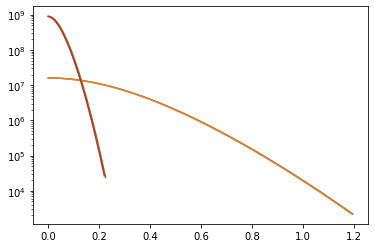

In [103]:
l2 = [1.603149e+07, 1.600087e+07, 1.593984e+07, 1.584879e+07, 1.572833e+07, 1.557925e+07, 1.540250e+07, 1.519923e+07, 1.497071e+07, 1.471837e+07, 1.444375e+07, 1.414848e+07, 1.383429e+07, 1.350297e+07, 1.315636e+07, 1.279632e+07, 1.242472e+07, 1.204344e+07, 1.165430e+07, 1.125912e+07, 1.085965e+07, 1.045758e+07, 1.005452e+07, 9.652009e+06, 9.251479e+06, 8.854276e+06, 8.461643e+06, 8.074718e+06, 7.694534e+06, 7.322019e+06, 6.957993e+06, 6.603174e+06, 6.258180e+06, 5.923532e+06, 5.599655e+06, 5.286889e+06, 4.985489e+06, 4.695631e+06, 4.417421e+06, 4.150895e+06, 3.896030e+06, 3.652748e+06, 3.420920e+06, 3.200375e+06, 2.990899e+06, 2.792250e+06, 2.604151e+06, 2.426306e+06, 2.258395e+06, 2.100085e+06, 1.951027e+06, 1.810867e+06, 1.679242e+06, 1.555786e+06, 1.440134e+06, 1.331921e+06, 1.230787e+06, 1.136374e+06, 1.048335e+06, 9.663271e+05, 8.900187e+05, 8.190870e+05, 7.532200e+05, 6.921168e+05, 6.354880e+05, 5.830560e+05, 5.345551e+05, 4.897319e+05, 4.483448e+05, 4.101640e+05, 3.749719e+05, 3.425622e+05, 3.127400e+05, 2.853212e+05, 2.601327e+05, 2.370116e+05, 2.158048e+05, 1.963689e+05, 1.785697e+05, 1.622815e+05, 1.473871e+05, 1.337772e+05, 1.213499e+05, 1.100106e+05, 9.967132e+04, 9.025030e+04, 8.167188e+04, 7.386596e+04, 6.676772e+04, 6.031723e+04, 5.445920e+04, 4.914262e+04, 4.432052e+04, 3.994965e+04, 3.599024e+04, 3.240577e+04, 2.916269e+04, 2.623026e+04, 2.358029e+04, 2.118699e+04, 1.902675e+04, 1.707801e+04, 1.532106e+04, 1.373792e+04, 1.231219e+04, 1.102894e+04, 9.874561e+03, 8.836679e+03, 7.904039e+03, 7.066420e+03, 6.314538e+03, 5.639973e+03, 5.035090e+03, 4.492971e+03, 4.007352e+03, 3.572567e+03, 3.183490e+03, 2.835491e+03, 2.524386e+03, 2.246403e+03,]
l3 = [9.044617e+08, 9.008745e+08, 8.937507e+08, 8.831900e+08, 8.693384e+08, 8.523842e+08, 8.325533e+08, 8.101027e+08, 7.853146e+08, 7.584892e+08, 7.299385e+08, 6.999788e+08, 6.689254e+08, 6.370860e+08, 6.047564e+08, 5.722156e+08, 5.397232e+08, 5.075160e+08, 4.758067e+08, 4.447829e+08, 4.146064e+08, 3.854136e+08, 3.573167e+08, 3.304041e+08, 3.047424e+08, 2.803781e+08, 2.573390e+08, 2.356368e+08, 2.152687e+08, 1.962191e+08, 1.784621e+08, 1.619627e+08, 1.466786e+08, 1.325619e+08, 1.195605e+08, 1.076188e+08, 9.667946e+07, 8.668402e+07, 7.757369e+07, 6.929016e+07, 6.177611e+07, 5.497572e+07, 4.883502e+07, 4.330219e+07, 3.832780e+07, 3.386493e+07, 2.986931e+07, 2.629933e+07, 2.311608e+07, 2.028331e+07, 1.776736e+07, 1.553715e+07, 1.356401e+07, 1.182162e+07, 1.028589e+07, 8.934818e+06, 7.748404e+06, 6.708487e+06, 5.798634e+06, 5.004013e+06, 4.311274e+06, 3.708430e+06, 3.184743e+06, 2.730620e+06, 2.337508e+06, 1.997802e+06, 1.704755e+06, 1.452392e+06, 1.235437e+06, 1.049239e+06, 8.897097e+05, 7.532589e+05, 6.367437e+05, 5.374178e+05, 4.528858e+05, 3.810633e+05, 3.201397e+05, 2.685460e+05, 2.249245e+05, 1.881032e+05, 1.570723e+05, 1.309632e+05, 1.090305e+05, 9.063542e+04, 7.523184e+04, 6.235364e+04, 5.160370e+04, 4.264433e+04, 3.518891e+04, 2.899459e+04, 2.385598e+04,]
l4 = [
    8.956246e+08, 8.411371e+08, 7.434522e+08, 6.207473e+08, 4.919439e+08, 3.719144e+08, 2.695020e+08, 1.879584e+08, 1.265891e+08, 8.254507e+07, 5.221403e+07, 3.208484e+07, 1.917244e+07, 1.114939e+07, 6.313562e+06, 3.482994e+06, 1.872675e+06, 9.816685e+05, 5.018971e+05, 2.503599e+05, 1.218904e+05, 5.794096e+04, 2.690133e+04
]
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(len(l))*0.0025,l)
ax.plot(np.arange(len(l2))*0.01, l2)
ax.plot(np.arange(len(l3))*0.0025,l3)
ax.plot(np.arange(len(l4))*0.01, l4)
ax.set_yscale('log')

In [98]:
2048 / 8192

0.25